In [3]:
using PyPlot, HDF5
path = "/Users/inchani/.julia/download/"
x2d_obs    = h5read(string(path,"data_set2.h5"), "x2d_obs")
fx2d_obs   = h5read(string(path,"data_set2.h5"), "fx2d_obs")
μx = mean(x2d_obs[:,1])
μy = mean(x2d_obs[:,2])
μobs = mean(fx2d_obs);

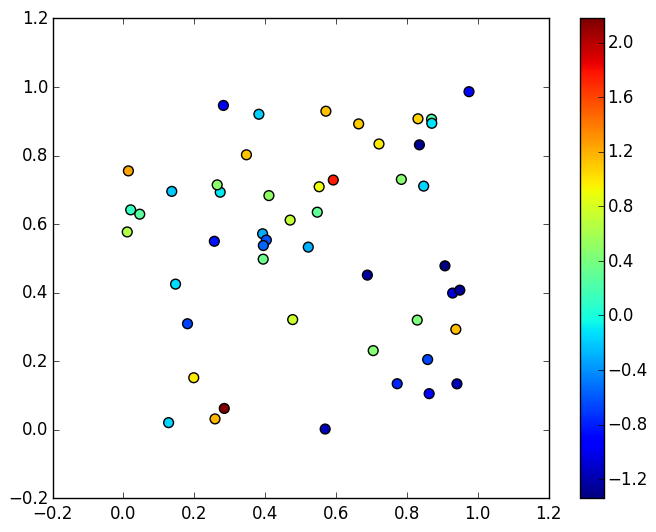

PyObject <matplotlib.colorbar.Colorbar instance at 0x323b72c68>

/Users/inchani/python/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [4]:
scatter(x2d_obs[:,1], x2d_obs[:,2], c=fx2d_obs, s = 50, vmin = minimum(fx2d_obs), vmax = maximum(fx2d_obs))
colorbar()

In [5]:
cov1(x,y) = exp(-norm(x-y))
cov2(x,y) = (norm(x)^0.85 + norm(y).^0.85 - norm(x-y).^0.85)
function cov3(x,y)
    ν    = 1.2
    ρ    = 0.01
    σ²   = 1.0
    arg  = √(2ν/ρ) * norm(x-y)
    if arg == 0.0
        return σ²
    else
        rtn  = arg^ν
        rtn *= besselk(ν, arg)
        rtn *= σ² * 2^(1-ν) / gamma(ν)
        return rtn
    end
end

cov3 (generic function with 1 method)

In [6]:
function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    (repmat(vx, m, 1), repmat(vy, 1, n))
end
meshgrid(v)  = meshgrid(v,v)

mesh_side    = 100
xmesh, ymesh = meshgrid(linspace(-.1, 1.1, mesh_side))

function ΣcrossΣpre1(xmesh, ymesh, x2d_obs)
    n = size(x2d_obs, 1)
    m = length(xmesh)
    Σcross = Array(Float64, m, n)
    Σpre   = Array(Float64, m, m)
    @inbounds for col in 1:n, row in 1:m
        Σcross[row, col] = cov1([xmesh[row], ymesh[row]], vec(x2d_obs[col,:]))
    end
    @inbounds for col in 1:m, row in 1:m
        Σpre[row, col] = cov1([xmesh[row], ymesh[row]], [xmesh[col], ymesh[col]])
    end
    return Σcross, Σpre
end
function ΣcrossΣpre2(xmesh, ymesh, x2d_obs)
    n = size(x2d_obs, 1)
    m = length(xmesh)
    Σcross = Array(Float64, m, n)
    Σpre   = Array(Float64, m, m)
    @inbounds for col in 1:n, row in 1:m
        Σcross[row, col] = cov2([xmesh[row], ymesh[row]], vec(x2d_obs[col,:]))
    end
    @inbounds for col in 1:m, row in 1:m
        Σpre[row, col] = cov2([xmesh[row], ymesh[row]], [xmesh[col], ymesh[col]])
    end
    return Σcross, Σpre
end
function ΣcrossΣpre3(xmesh, ymesh, x2d_obs)
    n = size(x2d_obs, 1)
    m = length(xmesh)
    Σcross = Array(Float64, m, n)
    Σpre   = Array(Float64, m, m)
    @inbounds for col in 1:n, row in 1:m
        Σcross[row, col] = cov3([xmesh[row], ymesh[row]], vec(x2d_obs[col,:]))
    end
    @inbounds for col in 1:m, row in 1:m
        Σpre[row, col] = cov3([xmesh[row], ymesh[row]], [xmesh[col], ymesh[col]])
    end
    return Σcross, Σpre
end

ΣcrossΣpre3 (generic function with 1 method)

In [7]:
Σcross1, Σpre1 = ΣcrossΣpre1(xmesh, ymesh, x2d_obs);
Σcross2, Σpre2 = ΣcrossΣpre2(xmesh, ymesh, x2d_obs);
Σcross3, Σpre3 = ΣcrossΣpre3(xmesh, ymesh, x2d_obs);

In [8]:
l = size(x2d_obs, 1)
Σobs1     = Array(Float64, l, l)
Σobs2     = Array(Float64, l, l)
Σobs3     = Array(Float64, l, l)
@inbounds for col in 1:l, row in 1:l
    Σobs1[row, col] = cov1(vec(x2d_obs[row,:]), vec(x2d_obs[col,:]))
    Σobs2[row, col] = cov2(vec(x2d_obs[row,:]), vec(x2d_obs[col,:]))
    Σobs3[row, col] = cov3(vec(x2d_obs[row,:]), vec(x2d_obs[col,:]))
end
Σobs1 += (0.1)^2 * eye(l);
Σobs2 += (0.1)^2 * eye(l);
Σobs3 += (0.1)^2 * eye(l);

fx_ept1 = Σcross3 *  inv(Σobs1) * fx2d_obs 
fx_ept2 = Σcross3 *  inv(Σobs2) * fx2d_obs 
fx_ept3 = Σcross3 *  inv(Σobs3) * fx2d_obs 

fx_ept1_reshape = Array(Float64, mesh_side, mesh_side)
fx_ept2_reshape = Array(Float64, mesh_side, mesh_side)
fx_ept3_reshape = Array(Float64, mesh_side, mesh_side)
ind = 1
@inbounds for col in 1:mesh_side, row in 1:mesh_side
    fx_ept1_reshape[row, col] = fx_ept1[ind]
    fx_ept2_reshape[row, col] = fx_ept2[ind]
    fx_ept3_reshape[row, col] = fx_ept3[ind]    
    ind +=1
end

In [15]:
σ1 = Σpre1  - Σcross1 * inv(Σobs1) * transpose(Σcross1);
σ2 = Σpre2  - Σcross2 * inv(Σobs2) * transpose(Σcross2);
σ3 = Σpre3  - Σcross3 * inv(Σobs3) * transpose(Σcross3);
L1 = chol(σ1, Val{:L});
L2 = chol(σ2, Val{:L});
L3 = chol(σ3, Val{:L});

fx_sim1 = fx_ept1 + L1 * randn(10000)
fx_sim2 = fx_ept2 + L2 * randn(10000)
fx_sim3 = fx_ept3 + L3 * randn(10000)

fx_sim1_reshape = Array(Float64, mesh_side, mesh_side)
fx_sim2_reshape = Array(Float64, mesh_side, mesh_side)
fx_sim3_reshape = Array(Float64, mesh_side, mesh_side)
ind = 1
@inbounds for col in 1:mesh_side, row in 1:mesh_side
    fx_sim1_reshape[row, col] = fx_sim1[ind]
    fx_sim2_reshape[row, col] = fx_sim2[ind]
    fx_sim3_reshape[row, col] = fx_sim3[ind]    
    ind +=1
end


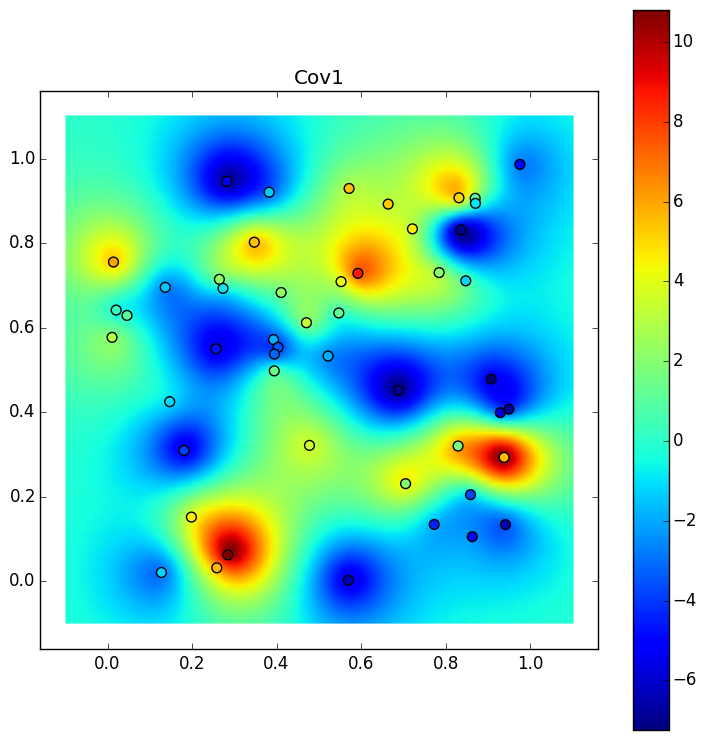

PyObject <matplotlib.text.Text object at 0x3135292d0>

In [9]:
figure(figsize=(9,9))
imshow(fx_ept1_reshape, origin='l',vmin = minimum(fx_ept1_reshape), vmax = maximum(fx_ept1_reshape),
extent= [-.1,1.1,-.1,1.1])
colorbar();
scatter(x2d_obs[:,1], x2d_obs[:,2], c=fx2d_obs, s = 50)
title("Cov1")


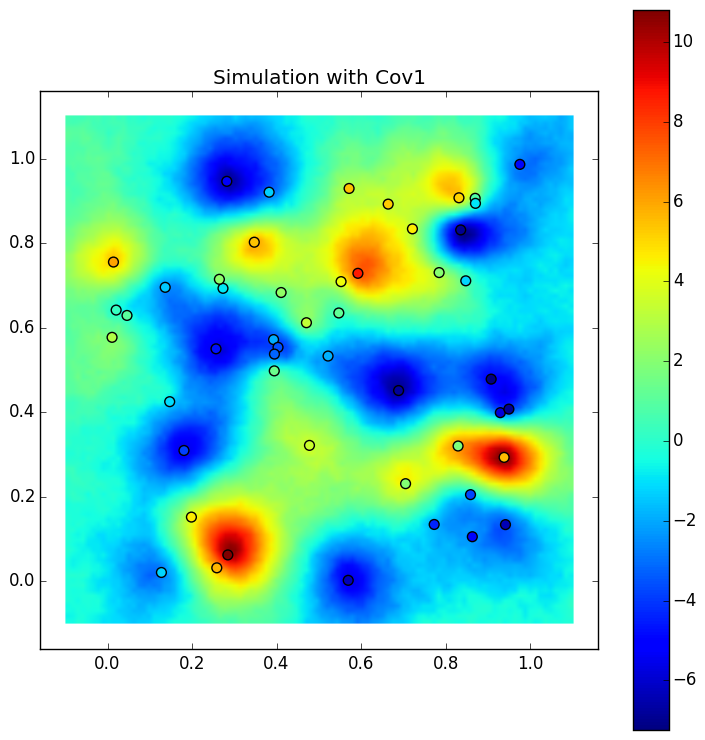

PyObject <matplotlib.text.Text object at 0x313782d10>

In [16]:
figure(figsize=(9,9))
imshow(fx_sim1_reshape, origin='l',vmin = minimum(fx_ept1_reshape), vmax = maximum(fx_ept1_reshape),
extent= [-.1,1.1,-.1,1.1])
colorbar();
scatter(x2d_obs[:,1], x2d_obs[:,2], c=fx2d_obs, s = 50)
title("Simulation with Cov1")

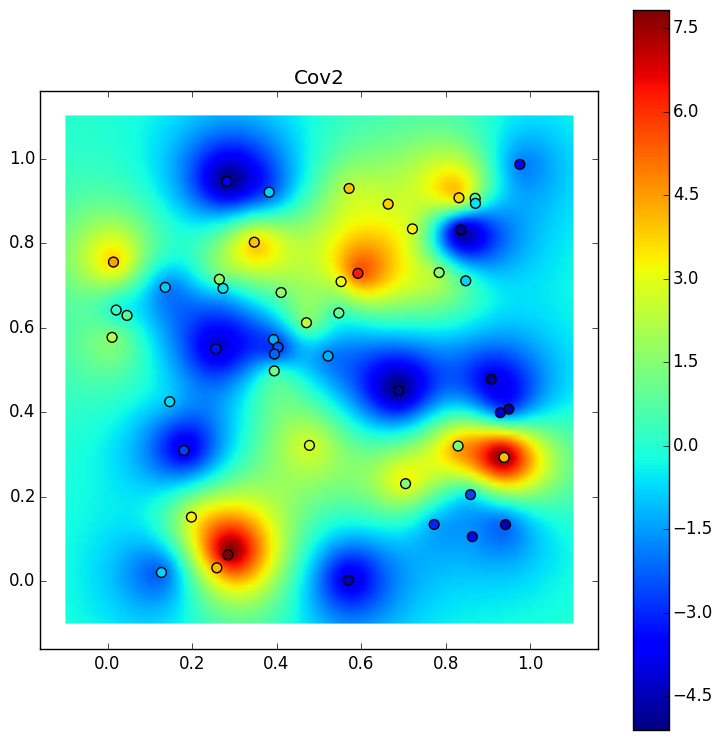

PyObject <matplotlib.text.Text object at 0x4a04e5c90>

In [209]:
figure(figsize=(9,9))
imshow(fx_ept2_reshape, origin='l',vmin = minimum(fx_ept2_reshape), vmax = maximum(fx_ept2_reshape),
extent= [-.1,1.1,-.1,1.1])
colorbar();
scatter(x2d_obs[:,1], x2d_obs[:,2], c=fx2d_obs, s = 50)
title("Cov2")

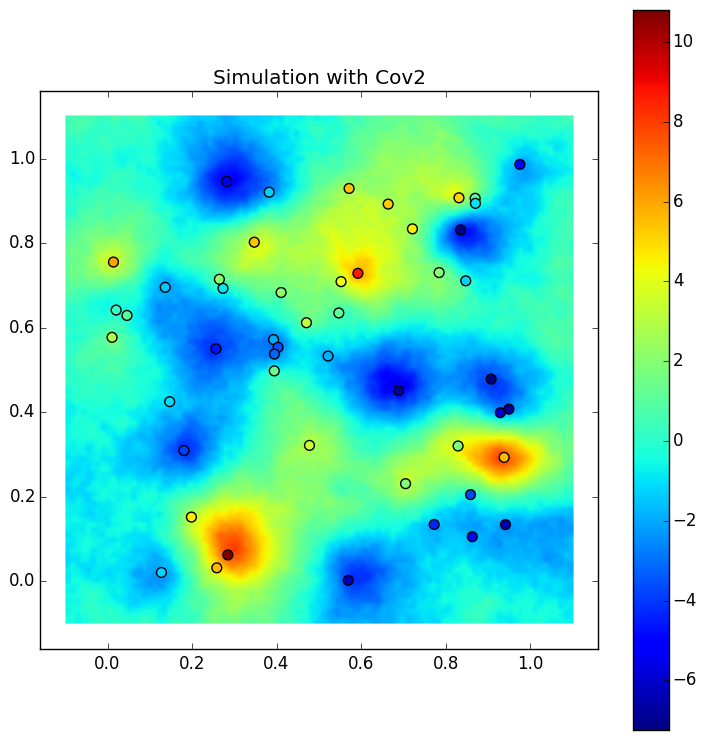

PyObject <matplotlib.text.Text object at 0x4177d1910>

In [17]:
figure(figsize=(9,9))
imshow(fx_sim2_reshape, origin='l',vmin = minimum(fx_ept1_reshape), vmax = maximum(fx_ept1_reshape),
extent= [-.1,1.1,-.1,1.1])
colorbar();
scatter(x2d_obs[:,1], x2d_obs[:,2], c=fx2d_obs, s = 50)
title("Simulation with Cov2")

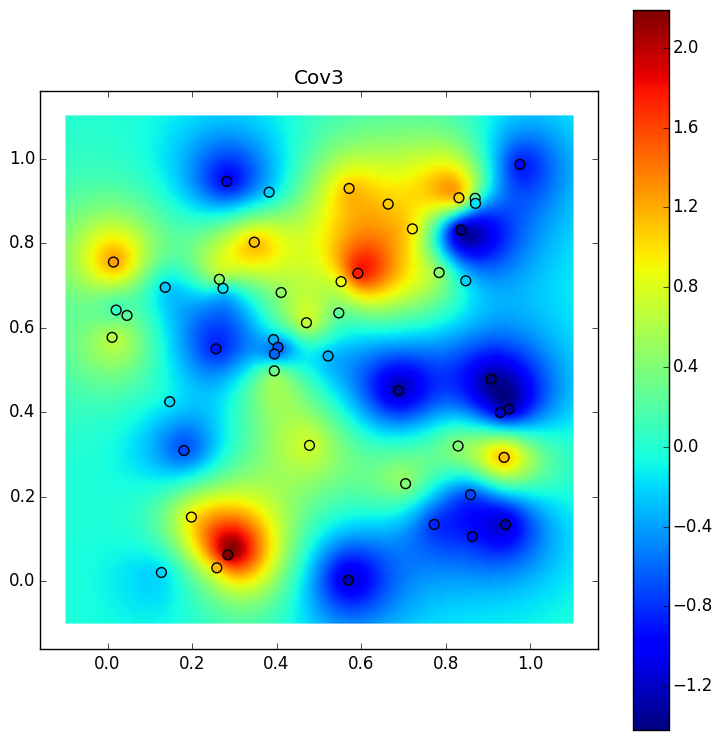

PyObject <matplotlib.text.Text object at 0x3b77a69d0>

In [18]:
figure(figsize=(9,9))
imshow(fx_ept3_reshape, origin='l',vmin = minimum(fx_ept3_reshape), vmax = maximum(fx_ept3_reshape),
extent= [-.1,1.1,-.1,1.1])
colorbar();
scatter(x2d_obs[:,1], x2d_obs[:,2], c=fx2d_obs, s = 50)
title("Cov3")

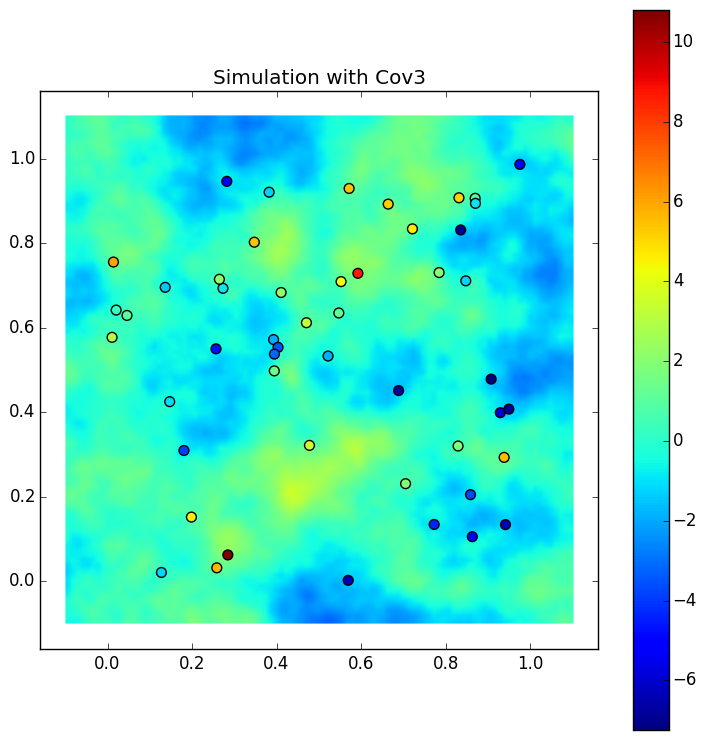

PyObject <matplotlib.text.Text object at 0x418d1c510>

In [21]:
figure(figsize=(9,9))
imshow(fx_sim3_reshape, origin='l',vmin = minimum(fx_ept1_reshape), vmax = maximum(fx_ept1_reshape),
extent= [-.1,1.1,-.1,1.1])
colorbar();
scatter(x2d_obs[:,1], x2d_obs[:,2], c=fx2d_obs, s = 50)
title("Simulation with Cov3")

In [23]:
logP1 = -0.5 * transpose(fx2d_obs) * inv(Σobs1) * (fx2d_obs)  - log(√((2π)^50.) * √(det(Σobs1)))
logP2 = -0.5 * transpose(fx2d_obs) * inv(Σobs2) * (fx2d_obs)  - log(√((2π)^50.) * √(det(Σobs2)))
logP3 = -0.5 * transpose(fx2d_obs) * inv(Σobs3) * (fx2d_obs)  - log(√((2π)^50.) * √(det(Σobs3)))
logP1, logP2,  logP3

([-113.71413373397607],[-87.50311479676996],[-56.67830452485151])

In [ ]:
# Cov3 has the maximum likelihood.